name: Module_EGFR_1 | forward specie(s): EGFR | backward specie(s): uEGFR | type: MichaelisMentenGeneral
name: Module_EGFR_2 | forward specie(s): EGFR | backward specie(s): pEGFR | type: MichaelisMentenGeneral



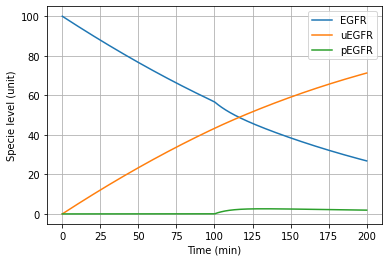

In [1]:
import numpy as np
from src.OdeModel import OdeModel
import src.reactions as re

Module_EGFR = OdeModel('Module_EGFR')
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'uEGFR', noBackward=True, Vmax_f=1))
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'pEGFR'))
Module_EGFR.specieConc(['EGFR'], [100])
print(Module_EGFR)

Module_EGFR.addActivation('EGF', 8.33, 100)
Module_EGFR.addStimulator('Module_EGFR_2', 'EGF')

Module_EGFR.simulate_beta(200)
Module_EGFR.plot(ignore_list=['EGF'])


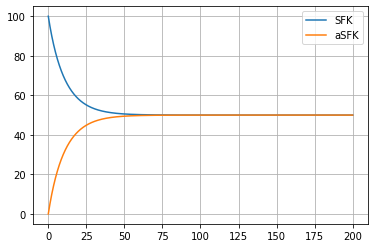

In [14]:
Module_SFK = OdeModel('Module_SFK')
Module_SFK.addReaction(re.MichaelisMentenGeneral('SFK', 'aSFK'))
Module_SFK.specieConc(['SFK'], [100])

Module_SFK.simulate_beta(200)
Module_SFK.plot()

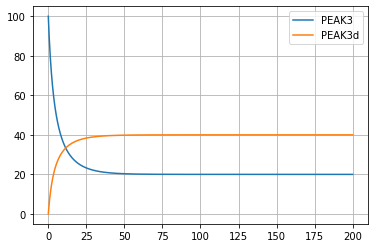

In [15]:
Module_PEAK3d = OdeModel('Module_PEAK3d')
Module_PEAK3d.addReaction(re.MassAction('PEAK3', 'PEAK3', 'PEAK3d'))
Module_PEAK3d.specieConc(['PEAK3'], [100])

Module_PEAK3d.simulate_beta(200)
Module_PEAK3d.plot()

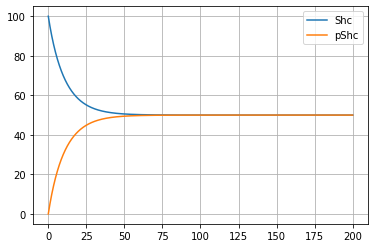

In [16]:
Module_Shc = OdeModel('Module_Shc')
Module_Shc.addReaction(re.MichaelisMentenGeneral('Shc', 'pShc'))
Module_Shc.specieConc(['Shc'], [100])

Module_Shc.simulate_beta(200)
Module_Shc.plot()


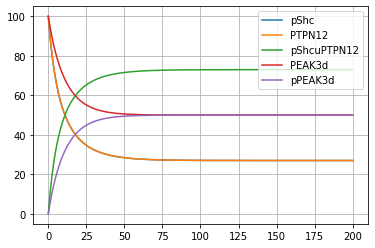

In [19]:
Module_pPEAK = OdeModel('Module_pPEAK')
Module_pPEAK.addReaction(re.MassAction('pShc', 'PTPN12'))
Module_pPEAK.addReaction(re.MichaelisMentenGeneral('PEAK3d', 'pPEAK3d', noBackward=True))

Module_pPEAK.specieConc(['pShc', 'PEAK3d'], [100, 100])
Module_pPEAK.specieConc(['PTPN12'], [100])

Module_pPEAK.simulate_beta(200)
Module_pPEAK.plot()